### Ex 4.1: Interest point detector Implement one or more keypoint detectors and compare their performance (with your own or with a classmate’s detector)<br>
• Forstner–Harris Hessian (try different formula variants given in ( ¨ 4.9–4.11));

In [100]:
# import 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# draw function:
def plt_show(title,img,cmap = None):
    fig = plt.figure()
    plt.imshow(img,cmap = cmap)
    plt.title(title)
    plt.show()

In [4]:
# transfer int to uint:
def int2uint(number):
    if len(number.shape)>1:
        number[number<0] = 0
        number[number>255] = 255
        return number.astype('uint8')

In [115]:
# 缩放图像至0-1之间：
def scale(img):
    return (img - np.min(img))/(np.max(img) - np.min(img))

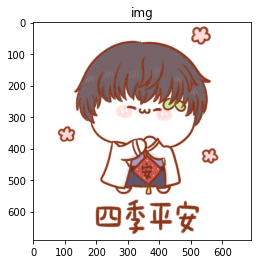

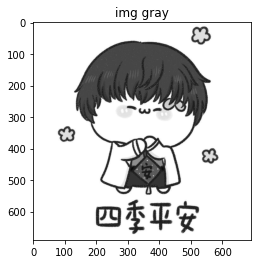

In [5]:
# load image:
img = cv2.imread('Lucien.jpg')
# show:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_color = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt_show("img",img_color)
plt_show("img gray",img_gray,cmap="gray")

#### Compute image derivatives (optionally, blur first).
image derivatives:Ix&Iy
- Ix kernel: [1 -1]/[-1 0 1]
- Iy kernel: Ix.T

In [15]:
kernel = np.array([-1,0,1])

In [125]:
# 计算图像每个点的偏导：
def cal_derivative(imgg,kernel,axis):
    img = copy.deepcopy(imgg)
    # 缩放到0-1之间：
    img = scale(img)
    img = np.array(img,dtype='float32')
    dev = np.zeros(img.shape,dtype='float32')
    # 横向卷积-Ix：
    if axis==1:
        for i in range(img.shape[0]):
            t = np.convolve(img[i,:],kernel)
            # fix size:
            dev[i,:] = t[:img.shape[1]]
    # 纵向卷积-Iy：
    elif axis==0:
        for j in range(img.shape[1]):
            t = np.convolve(img[:,j],kernel)
            # fix size:
            dev[:,j] = t[:img.shape[0]]
    
    return dev

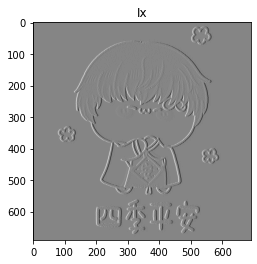

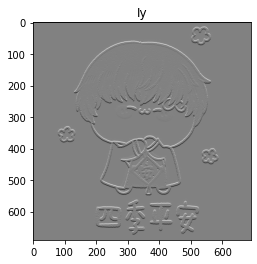

In [126]:
# 一阶偏导计算结果：
Ix = cal_derivative(img_gray,kernel,1)
plt_show("Ix",Ix,cmap="gray")
Iy = cal_derivative(img_gray,kernel,0)
plt_show("Iy",Iy,cmap="gray")

#### Compute M components as squares of derivatives.
[[IxIx   IxIy],[IxIy,IyIy]] = [[Ix],[Iy]]*[Ix,Iy]

In [77]:
# 计算M
def cal_MComponent(Ix,Iy):
    Ix2 = np.square(Ix)
    Ixy = Ix*Iy
    Iy2 = np.square(Iy)
    M_c = [[Ix2,Ixy],[Ixy,Iy2]]
    return np.array(M_c)

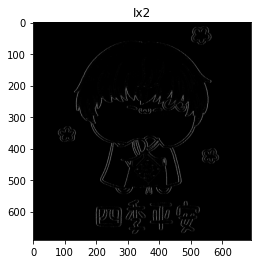

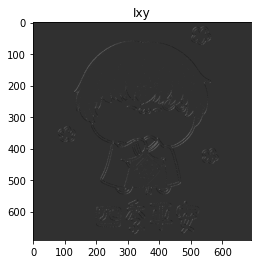

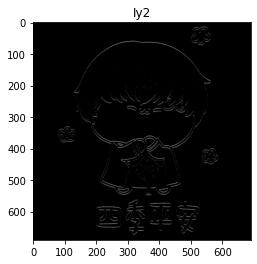

In [120]:
M_component = cal_MComponent(Ix,Iy)
plt_show("Ix2",M_component[0,0],cmap="gray")
plt_show("Ixy",M_component[0,1],cmap="gray")
plt_show("Iy2",M_component[1,1],cmap="gray")


#### Gaussian filter g() with width sigma

In [133]:
def gauss_filter(M_component):
    ksize = (3,3)
    sigmaX = 1
    gIx2 = cv2.GaussianBlur(M_component[0,0],ksize,sigmaX)
    gIxy = cv2.GaussianBlur(M_component[0,1],ksize,sigmaX)
    gIy2 = cv2.GaussianBlur(M_component[1,1],ksize,sigmaX)
    GM_component = [[gIx2,gIxy],[gIxy,gIy2]]

    return np.array(GM_component,dtype='float32') 


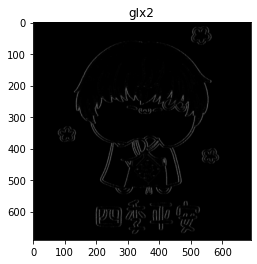

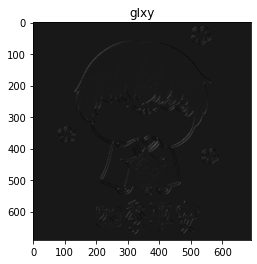

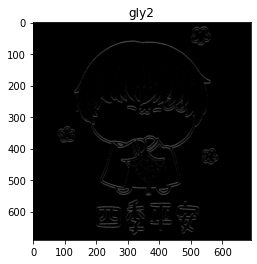

In [134]:
GM_component = gauss_filter(M_component)
plt_show("gIx2",GM_component[0,0],cmap="gray")
plt_show("gIxy",GM_component[0,1],cmap="gray")
plt_show("gIy2",GM_component[1,1],cmap="gray")

#### Compute cornerness
C = det(M)-alpha*trace(M)^2<br>
= g(Ix2)* g(Iy2)-g(Ix * Iy)^2 - alpha[g(Ix2)+g(Iy2)]^^2

In [272]:
def cal_cornerness(GM_component):
    alpha = 0.05
    C = GM_component[0,0]*GM_component[1,1]-GM_component[0,1]*GM_component[1,0]-alpha*(GM_component[0,0]+GM_component[1,1])**2
    return C

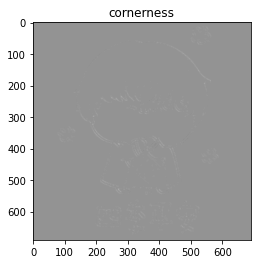

In [250]:
C = cal_cornerness(GM_component)
plt_show("cornerness",scale(C),cmap="gray")

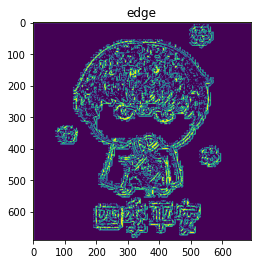

In [197]:
# 找到edge：
edges = np.array(C<0, dtype=np.float32)
plt_show("edge",edges)

In [278]:
# 使用阈值找到high cornerness:
# 方法一：计算窗口区域内的极大值点
def threshold_v1(C):
    # 局部最大值：在窗口区域内挑出极大值点
    ksize = 3
    C_tt = np.zeros((C.shape))
    for i in range(0,C.shape[0],ksize):
        for j in range(0,C.shape[1],ksize):
            t = C[i:i+ksize,j:j+ksize]
            pos = np.where(t==np.max(t))
            if np.max(t)>0.01:
                # 取一个
                x,y = pos[0][0],pos[1][0]
                C_tt[i+x,j+y] = 255
    return int2uint(C_tt)

In [277]:
# 使用阈值找到high cornerness:
# 方法二：使用分位点
def threshold_v2(C,value):
    # 总体分类：使用分位数，设置大于90%的为角点candidate:
    points = np.array(C>np.percentile(C, value), dtype=np.float32)
    points[points==1] = 255
    return int2uint(points)

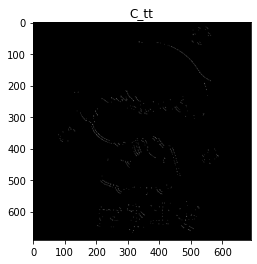

In [274]:
C_tt = threshold_v1(C)
plt_show("C_tt",C_tt,cmap="gray")

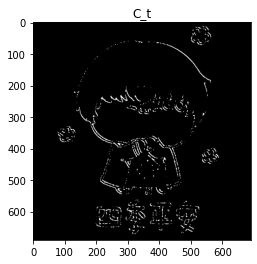

In [282]:
C_t = threshold_v2(C,98)
plt_show("C_t",C_t,cmap="gray")

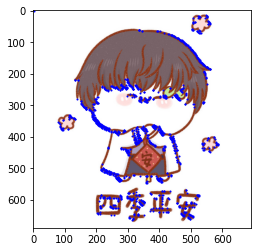

In [271]:
pos = np.array(np.where(C_tt==255))
img_p = copy.deepcopy(img_color)
fig = plt.figure()
plt.imshow(img_color)
plt.scatter(pos[1],pos[0],c='b',marker='o',s=1)
plt.show()

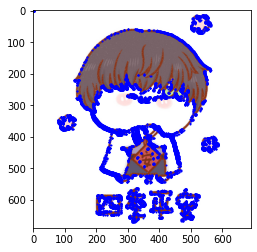

In [284]:
pos_t = np.array(np.where(C_t==255))
img_pp = copy.deepcopy(img_color)
fig = plt.figure()
plt.imshow(img_pp)
plt.scatter(pos_t[1],pos_t[0],c='b',marker='o',s=1)
plt.show()


In [285]:
# 全过程：
def process(file):
    
    # load image:
    img = cv2.imread(file)
    # show:
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_color = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt_show("img",img_color)
    plt_show("img gray",img_gray,cmap="gray")
    
    # kernel
    kernel = np.array([-1,0,1]) 
    # 一阶偏导计算结果：
    Ix = cal_derivative(img_gray,kernel,1)
    plt_show("Ix",Ix,cmap="gray")
    Iy = cal_derivative(img_gray,kernel,0)
    plt_show("Iy",Iy,cmap="gray")
    # 计算M：
    M_component = cal_MComponent(Ix,Iy)
    plt_show("Ix2",M_component[0,0],cmap="gray")
    plt_show("Ixy",M_component[0,1],cmap="gray")
    plt_show("Iy2",M_component[1,1],cmap="gray")
    # 高斯filter：
    GM_component = gauss_filter(M_component)
    plt_show("gIx2",GM_component[0,0],cmap="gray")
    plt_show("gIxy",GM_component[0,1],cmap="gray")
    plt_show("gIy2",GM_component[1,1],cmap="gray")
    # 计算cornerness:
    C = cal_cornerness(GM_component)
    plt_show("cornerness",scale(C),cmap="gray")

    # edge展示
    edges = np.array(C<0, dtype=np.float32)
    plt_show("edge",edges)
    # 角点筛选：
    C_tt = threshold_v1(C)
    plt_show("C_tt",C_tt,cmap="gray")
    # 结果展示
    pos = np.array(np.where(C_tt==255))
    img_p = copy.deepcopy(img_color)
    fig = plt.figure()
    plt.imshow(img_p)
    plt.scatter(pos[1],pos[0],c='b',marker='o',s=1)
    plt.show()
    
    # 结果展示
    C_t = threshold_v2(C,98)
    plt_show("C_t",C_t,cmap="gray")
    pos_t = np.array(np.where(C_t==255))
    img_pp = copy.deepcopy(img_color)
    fig = plt.figure()
    plt.imshow(img_pp)
    plt.scatter(pos_t[1],pos_t[0],c='b',marker='o',s=1)
    plt.show()
   
    return C_t

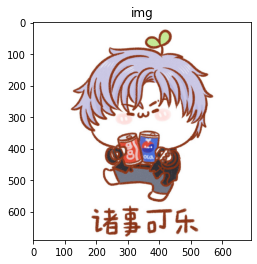

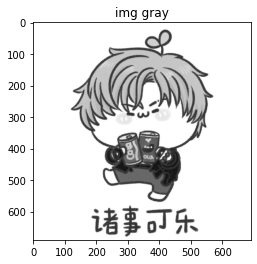

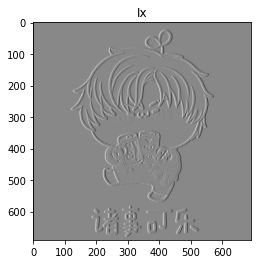

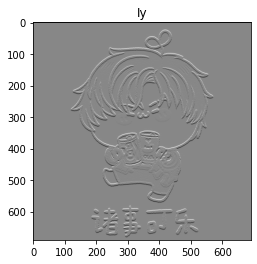

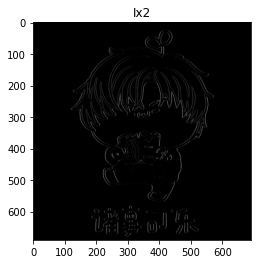

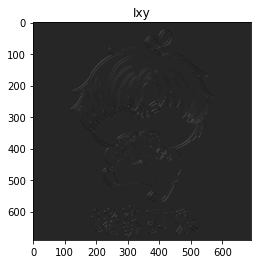

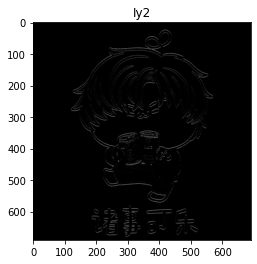

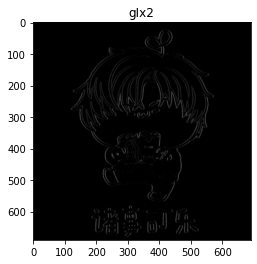

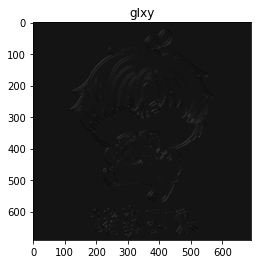

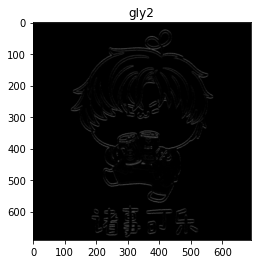

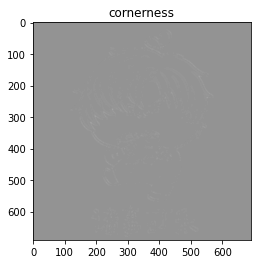

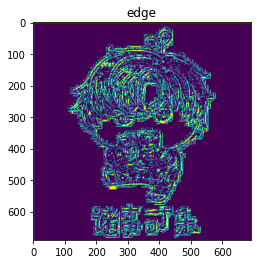

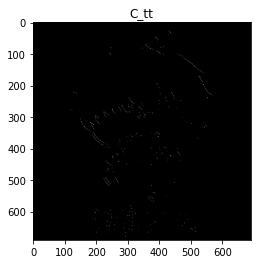

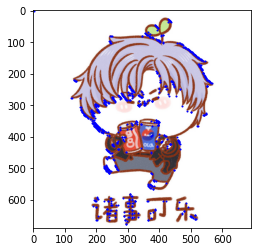

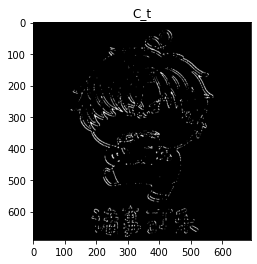

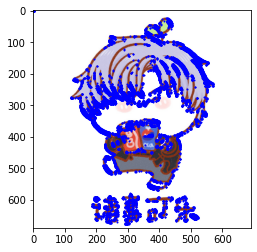

In [287]:
C_t = process("bilibili.jpg")